In [1]:
%matplotlib inline
import numpy as np
from anisotropic_potential import LayeredHalfspace, apparent_conductivity
from anisotropic_potential_obj import AnisotropicPotentialObjectiveFunction
from objfunc import ModelObjectiveFunction, FCMObjectiveFunction
from utils import eff_anis_trans
import matplotlib.pyplot as plt
from time import time
import scipy.sparse as sp
from scipy.optimize import minimize

from IPython import display

In [2]:
#Setting up model
sig1 = [10**-1, 10**-0.7, 10**0.25]
sig2 = [10**-0.4, 10**-0.3, 10**0]
sig3 = [10**-0.1, 10**-0.0, 10**0.25]
alpha = [5*np.pi/20, np.pi/8, 0]
betas = [3*np.pi/8, -3*np.pi/8, -2*np.pi/10]
gamma = [3*np.pi/16, 3*np.pi/8, np.pi/4]
zs = [0, 10, 50]

forward_space = LayeredHalfspace(zs, sig1, sig2, sig3, alpha, betas, gamma)

#Setting up observation points
wenner_distances= np.array([-3,-1,1,3])
scales = np.logspace(0,4.5,15)

Axs = wenner_distances[0]*scales
Mxs = wenner_distances[1]*scales
Nxs = wenner_distances[2]*scales
Bxs = wenner_distances[3]*scales
Ays = np.zeros_like(Axs)
Bys = np.zeros_like(Bxs)
Mys = np.zeros_like(Mxs)
Nys = np.zeros_like(Nxs)

#Rotations to perform:
rs = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4])
Xs_a, Ys_a = [],[]
Xs_b, Ys_b = [],[]
Xs_m, Ys_m = [],[]
Xs_n, Ys_n = [],[]
for r in rs:
    rot = np.array([[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]])
    
    x, y = rot@np.c_[Axs, Ays].T
    Xs_a.append(x), Ys_a.append(y)
    
    x, y = rot@np.c_[Bxs, Bys].T
    Xs_b.append(x), Ys_b.append(y)
    
    x, y = rot@np.c_[Mxs, Mys].T
    Xs_m.append(x), Ys_m.append(y)
    
    x, y = rot@np.c_[Nxs, Nys].T
    Xs_n.append(x), Ys_n.append(y)

Ax = np.hstack(Xs_a)
Ay = np.hstack(Ys_a)
Bx = np.hstack(Xs_b)
By = np.hstack(Ys_b)
Mx = np.hstack(Xs_m)
My = np.hstack(Ys_m)
Nx = np.hstack(Xs_n)
Ny = np.hstack(Ys_n)
    
A = np.c_[Ax, Ay].T
B = np.c_[Bx, By].T
M = np.c_[Mx, My].T
N = np.c_[Nx, Ny].T


In [3]:
volts = forward_space.voltage(A, B, M, N)
rhoa_true = apparent_conductivity(volts, A, B, M, N)
np.random.seed(1)
d_obs = volts+np.random.randn(*volts.shape)*volts*0.01
Wd = sp.diags(1/(0.01*volts))
rhoa_obs = apparent_conductivity(d_obs, A, B, M, N)

In [4]:
def halfspace_fit(x):
    #Setting up model
    half_space = LayeredHalfspace([0], [np.exp(x[0])], [np.exp(x[1])], [np.exp(x[2])], [x[3]], [0], [0])
    volts = half_space.voltage(A, B, M, N)
    delta_d = Wd@(d_obs - volts)
    return delta_d@delta_d

In [5]:
x0 = np.array([np.log(10**.25),np.log(10**.25),np.log(10**.25),0])
out = minimize(halfspace_fit, x0)
out

      fun: 143051.93824444973
 hess_inv: array([[ 8.59710641e-05,  4.25221549e-05, -4.37893415e-05,
         2.35759297e-06],
       [ 4.25221549e-05,  3.09216563e-05, -2.20496173e-05,
         4.17785244e-06],
       [-4.37893415e-05, -2.20496173e-05,  2.26538653e-05,
        -1.09328946e-06],
       [ 2.35759297e-06,  4.17785244e-06, -1.09328946e-06,
         7.19357718e-05]])
      jac: array([0.00585938, 0.00390625, 0.0078125 , 0.00390625])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 155
      nit: 16
     njev: 31
   status: 2
  success: False
        x: array([0.57310363, 0.2483724 , 0.20714851, 0.74223772])

In [6]:
halfspace_fit([10**.25,10**.25,10**.25,0]), halfspace_fit(out['x'])

(417882.2316714622, 143051.93824444973)

In [7]:
x_half = out['x']
n_inv_layers = 50
s1 = np.ones(n_inv_layers)*x_half[0]
s2 = np.ones(n_inv_layers)*x_half[1]
s3 = np.ones(n_inv_layers)*x_half[2]
a = np.ones(n_inv_layers)*x_half[3]
b = np.zeros(n_inv_layers)
g = np.zeros(n_inv_layers)
zs = np.logspace(0,3,50)-1 #log spaced widths
dz = zs[1:]-zs[:-1]
dz = np.append(dz,dz[-1])

mref = np.concatenate((s1, s2, s3, a, b, g))
mi = mref.copy()
options = {'disp':True}

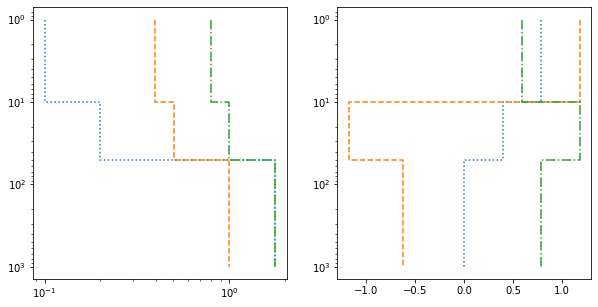

In [8]:
z = forward_space._z
zplot = np.array([1,z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(s1plot, zplot, ':')
plt.loglog(s2plot, zplot, "--")
plt.loglog(s3plot, zplot, "-.")
plt.gca().invert_yaxis()

aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])
plt.subplot(1,2,2)
plt.semilogy(aplot,zplot,':')
plt.semilogy(bplot,zplot,"--")
plt.semilogy(gplot,zplot,"-.")
plt.gca().invert_yaxis()

In [9]:
PhiD = AnisotropicPotentialObjectiveFunction(zs, (A, B, M, N), d_obs, Wd=Wd)
PhiD(mref)

143051.93824444976

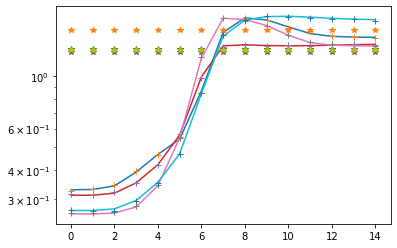

In [10]:
rhoa_pre_mi = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.semilogy(rhoa_true[15*i:(i+1)*15], label=i)
    plt.semilogy(rhoa_obs[15*i:(i+1)*15],'+')
    plt.semilogy(rhoa_pre_mi[15*i:(i+1)*15],'*')

In [11]:
weights = 1/(np.abs(zs)+1)**2
weights /= weights.max()
weights[-1] = 10
#weights2 = (weights[1:]+weights[:-1])/2

Wz = sp.diags(dz)*sp.diags([-1/dz,1/dz],[0,1],shape=(n_inv_layers,n_inv_layers))
Wz = sp.block_diag([Wz]*3+[Wz]*3).tocsr()
Ws = sp.block_diag([sp.diags(weights*np.sqrt(dz))]*3+[sp.diags(np.sqrt(dz))]*3)

W_anis = sp.diags([-1,-1,2,-1,-1],
                  [-2*n_inv_layers,-n_inv_layers,0,n_inv_layers,2*n_inv_layers],
                  shape=(3*n_inv_layers, 3*n_inv_layers))
W_anis = sp.block_diag((W_anis, sp.csr_matrix(W_anis.shape)))
PhiM = ModelObjectiveFunction(0.25*Ws.T@Ws+100*Wz.T@Wz+1*W_anis, mref=mref)
PhiM2 = ModelObjectiveFunction(100*Wz.T@Wz+1*W_anis, mref=mref)

In [12]:
mod_folder = "Models/mod3/"

In [13]:
def callback(x):
    print(0.5*Phi(x), PhiD(x), PhiM(x))

In [14]:
beta = 50
Phi = PhiD+beta*PhiM

x = mi
callback(x)
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-3)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta50',x)

71525.96912222488 143051.93824444976 0.0
31424.64243198211 53910.14591130117 178.7827790532608
9858.602895690929 13008.835715165034 134.16740152433644
5453.585062047379 5781.394080929308 102.51552086330899
4314.307101217322 4045.2287376691306 91.66770929531029
3984.900937588275 4084.050442301353 77.71502865750395
3460.8150420402744 3043.3108430614284 77.56638482038241
3086.8588621325634 2247.939935738981 78.51555577052292
2978.2867738848818 2064.961898095674 77.8322329934818
2837.5407166754885 1912.9119361783944 75.24338994345166
2811.1357148852903 1876.7785543453952 74.9098575085037
2808.2469297516836 1878.6648822596258 74.75657954487484
2807.4579062530606 1861.9392907396366 75.05953043532969
2806.8756172431463 1852.25239708589 75.22997674800806
2806.7553050714896 1851.824471567984 75.23372277149991
2806.716156442819 1852.048508431712 75.22767608907851
Optimization terminated successfully.
         Current function value: 2806.716156
         Iterations: 15
         Function evaluatio

In [15]:
beta = 10
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta50.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-5)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta10',x)

2604.325269322497 1852.048508431712 75.22767608907851
1186.6469931548 1428.6616951515653 94.46322911580344
1015.0301839198328 926.8767630120676 110.31836048275979
934.3281166571301 560.9721336145291 130.7684099699731
927.67002351921 541.1386693907488 131.42013776476713
916.5326983172879 504.13118624118863 132.89342103933873
906.103600418724 442.6411902664164 136.95660105710317
905.1478108578988 447.1005029867706 136.3195118729027
903.9545242277343 444.07392481505565 136.38351236404128
903.7632556627719 438.02692368091647 136.94995876446274
903.7092852026127 437.99433584206804 136.94242345631574
903.6993579815078 437.4429256179083 136.99557903451074
903.6901890084268 437.5324704164566 136.98479076003971
903.6889267600802 437.4627961622383 136.9915057357922
903.6881619742139 437.51349111202524 136.98628328364026
903.6880584601404 437.49696099764935 136.98791559226314
903.6879995732977 437.5081865273483 136.9867812619247
903.6879922033942 437.50387231073506 136.98721120960533
Optimization

In [16]:
beta = 2
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta10.npy')
callback(x)
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-6)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta2',x)

355.73914736497284 437.50387231073506 136.98721120960533
318.98036803046375 320.2385930473898 158.86107150676884
268.21714847223376 174.43807517588186 180.99811088429283
251.9295773519206 98.35116045896498 202.75399712243814
249.53424654916574 97.43286824077995 200.81781242877577
247.39425908942331 80.63032904621352 207.07909456631654
247.25515152289074 81.15318476192581 206.67855914192782
247.01257535281306 81.35985854788044 206.33264607887284
246.70544312555197 81.16597073550459 206.12245775779968
246.6580911029775 80.14375894400163 206.58621163097666
246.64793822139484 80.13752472876342 206.57917585701313
246.64043019597156 79.84085005777858 206.72000516708226
246.63831476933012 79.9551980941877 206.66071572223626
246.63762047312753 79.88145187911621 206.69689453356943
246.6372349576261 79.94354222110633 206.66546384707294
246.6370428834959 79.89019244752717 206.6919466597323
246.6369533243781 79.91678079807762 206.6785629253393
246.6368891631865 79.89226078402368 206.69075877117467

In [17]:
beta = 1
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta2.npy')
callback(x)
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-6)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta1',x)

143.293189616724 79.89906941842081 206.6873098150272
141.3850769183062 67.89126853529856 214.8788853013138
138.91872598857233 54.99068624029086 222.84676573685383
138.29950629070393 48.10392498483217 228.4950875965757
138.19801480194533 48.683867202391454 227.7121624014992
138.13302477754183 47.18236378525254 229.08368576983113
138.12854544929627 47.15278916175858 229.10430173683397
138.12571058959148 47.31850390510789 228.93291727407507
138.12486033636236 47.1997658811304 229.0499547915943
138.1247200189291 47.205697201878664 229.04374283597954
138.1245681322111 47.19972456276983 229.04941170165236
138.12453672792282 47.202662067239956 229.04641138860566
138.12452316665556 47.19852679435647 229.05051953895466
138.1245181057829 47.199097938648464 229.0499382729173
138.12451439139306 47.197619325298064 229.0514094574881
138.12451312265006 47.19840711676459 229.05061912853554
138.124512591646 47.19771990660186 229.0513052766902
138.12451239084658 47.197973355224825 229.05105142646832
138

In [18]:
#len(PhiD.d_pre)
x = np.load(mod_folder + 'beta1.npy')
print(PhiD(x))

47.19772090204334


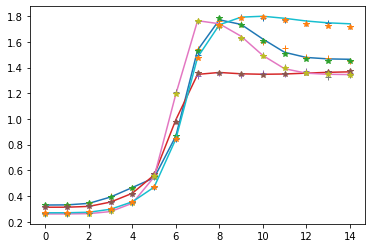

In [19]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre[15*i:(i+1)*15],'*')

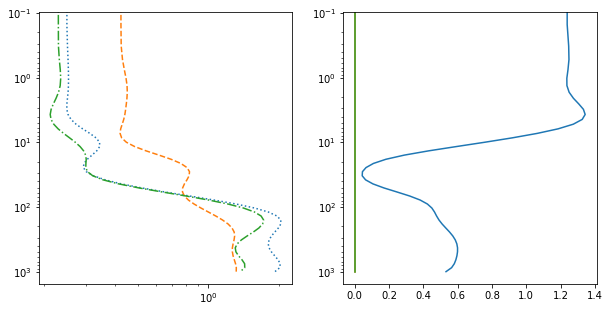

In [20]:
inv1 = np.exp(x.reshape(6,n_inv_layers)[0])
inv2 = np.exp(x.reshape(6,n_inv_layers)[1])
inv3 = np.exp(x.reshape(6,n_inv_layers)[2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(x.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

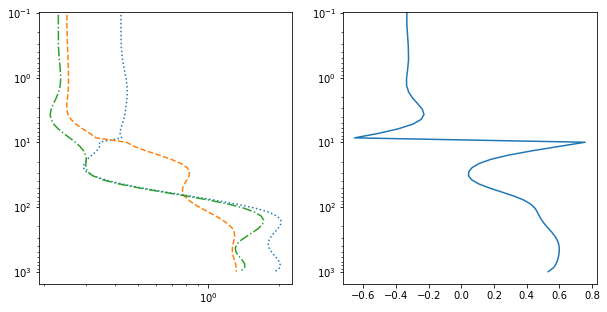

In [21]:
# Plot Effective Anisotropy:
mod = x.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

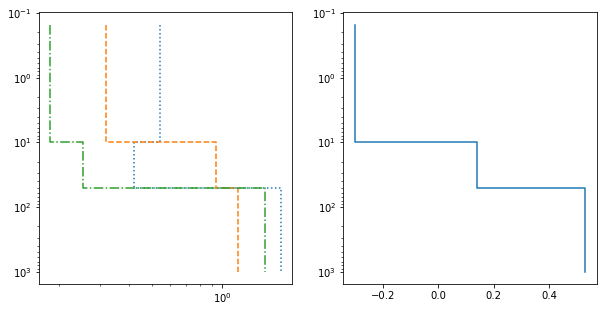

In [22]:
# Plot Effective Anisotropy:

zplot = np.array([zs[1],z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])
aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])

m_eff = eff_anis_trans(s1plot, s2plot, s3plot, aplot, bplot, gplot)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zplot,':')
plt.loglog(m_eff[1], zplot,"--")
plt.loglog(m_eff[2], zplot,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zplot)
plt.gca().invert_yaxis()

In [23]:
def plot_model(xi, u, i):

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
    inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
    inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])
    plt.loglog(inv1, zs,':')
    plt.loglog(inv2, zs,"--")
    plt.loglog(inv3, zs,"-.")
    plt.gca().invert_yaxis()

    plt.subplot(1,3,2)
    plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs,":")
    plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs,"--")
    plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs,"-.")
    plt.gca().invert_yaxis()
    plt.title('Iteration {}'.format(i+1))

    plt.subplot(1,3,3)
    inv1 = u[0]
    inv2 = u[1]
    inv3 = u[2]
    plt.semilogy(inv1, zs,':')
    plt.semilogy(inv2, zs,"--")
    plt.semilogy(inv3, zs,"-.")
    plt.gca().invert_yaxis()

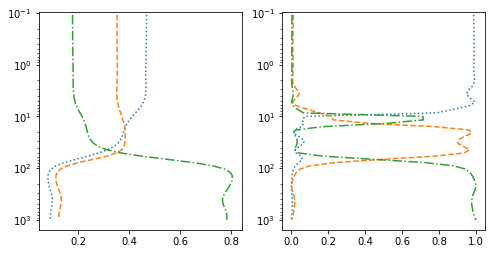

In [24]:
#sig1 = [10**-1, 10**-0.7, 10**0.25]
#sig2 = [10**-0.4, 10**-0.3, 10**0]
#sig3 = [10**-0.1, 10**-0.0, 10**0.25]
#alpha = [5*np.pi/20, np.pi/8, 0]
#betas = [3*np.pi/8, -3*np.pi/8, -2*np.pi/10]
#gamma = [3*np.pi/16, 3*np.pi/8, np.pi/4]

xi = np.load(mod_folder + 'beta1.npy')
log10 = np.log(10)
tk = np.array([[-1*log10, -0.4*log10, -0.1*log10, 5*np.pi/20, 3*np.pi/8, 3*np.pi/16],
               [-0.7*log10, -0.3*log10, -0*log10, np.pi/8, -3*np.pi/8, 3*np.pi/8],
               [0.25*log10, -0*log10, 0.25*log10, 0, -2*np.pi/10, np.pi/4]])
v = tk
PhiFCM = FCMObjectiveFunction(tk, 0)
for i in range(10):
    u = PhiFCM.updateU(x, v)
    v = PhiFCM.updateV(x, u, 0)
v_eff = v.copy()
v_eff[:,:3] = np.exp(v_eff[:,:3])
v_eff = np.c_[eff_anis_trans(*v_eff.T)]
v_eff[:, :3] = np.log(v_eff[:,:3])

tk_eff = tk.copy()
tk_eff[:,:3] = np.exp(tk_eff[:,:3])
tk_eff = np.c_[eff_anis_trans(*tk_eff.T)]
tk_eff[:, :3] = np.log(tk_eff[:,:3])

mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = np.r_[eff_anis_trans(*mod)].reshape(4, -1)
m_eff[:3] = np.log(m_eff[:3])
m_eff = m_eff.reshape(-1)

eta = 2

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v, w=[1,1,1,1,1,1])
PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta,  w=np.array([0.01,0.01,0.01,1]))

u = PhiFCM.updateU(xi, tk)
u_eff = PhiFCM_eff.updateU(m_eff, tk_eff)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(u[0], zs,':')
plt.semilogy(u[1], zs,"--")
plt.semilogy(u[2], zs,"-.")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.semilogy(u_eff[0], zs,':')
plt.semilogy(u_eff[1], zs,"--")
plt.semilogy(u_eff[2], zs,"-.")
plt.gca().invert_yaxis()

In [25]:
np.linalg.norm(v-tk), np.linalg.norm(v_eff-tk_eff)

(3.197763240809732, 0.5632328274507594)

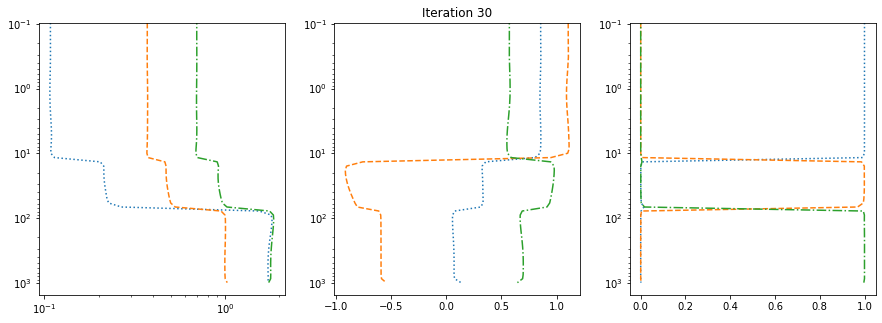

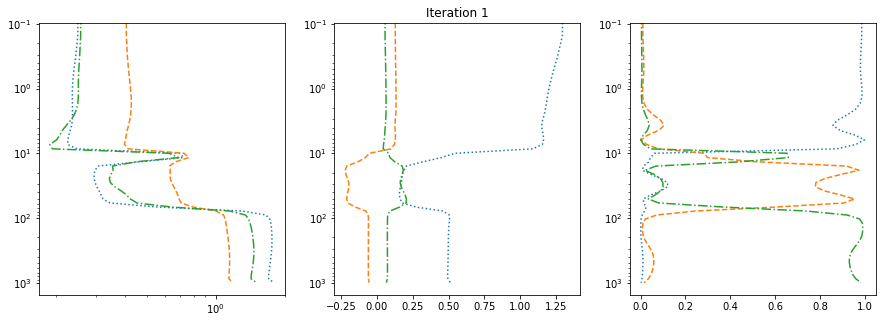

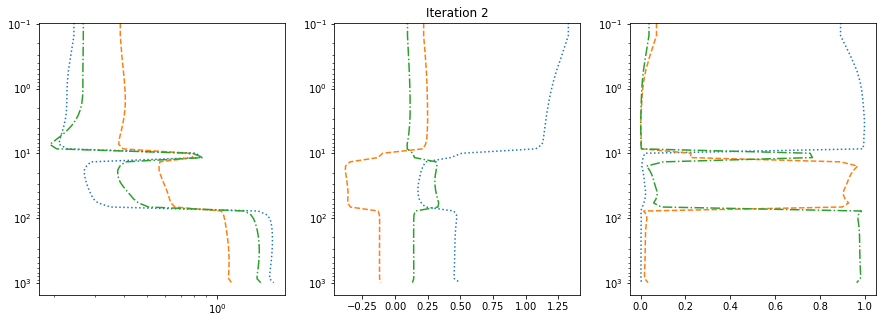

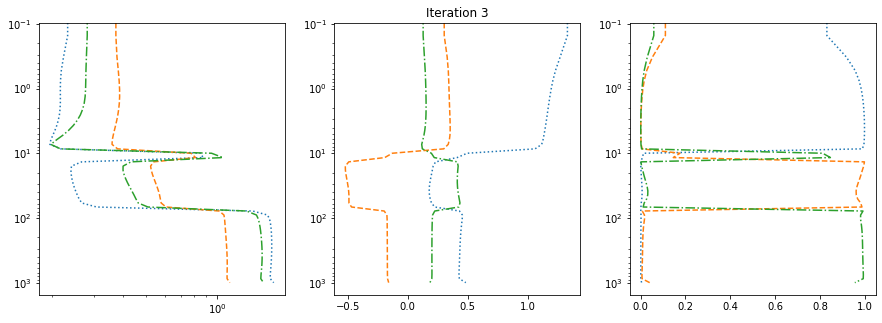

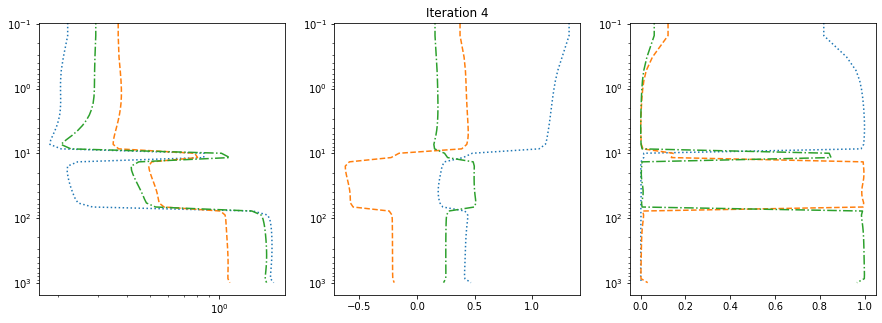

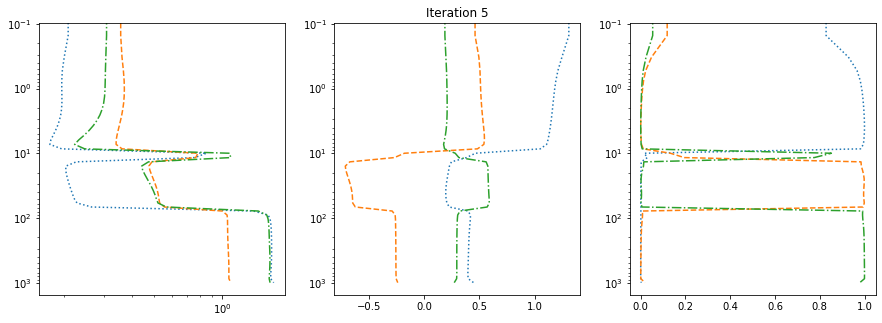

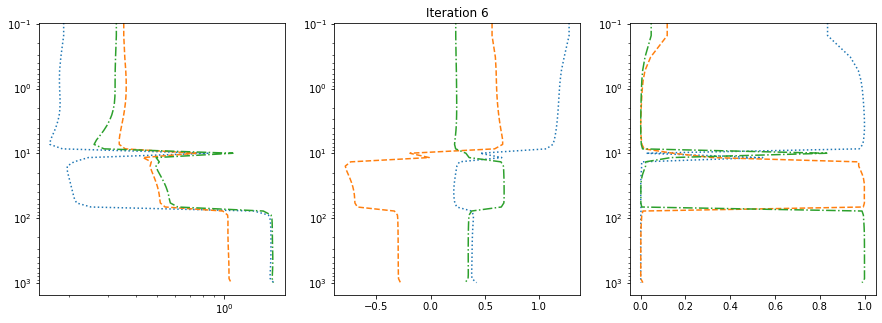

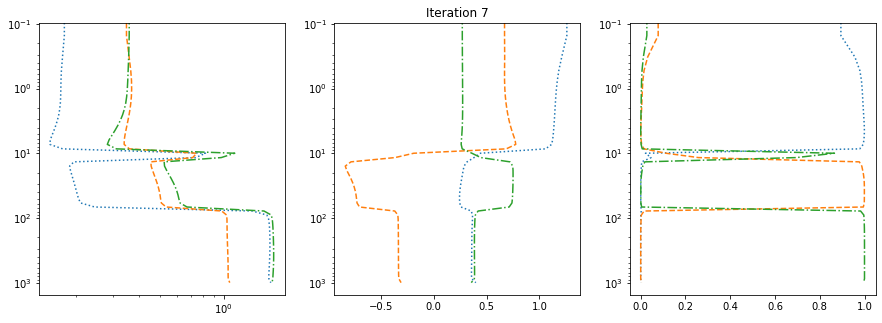

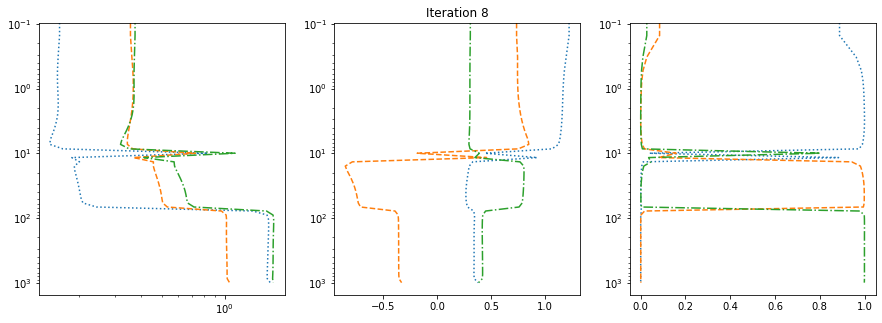

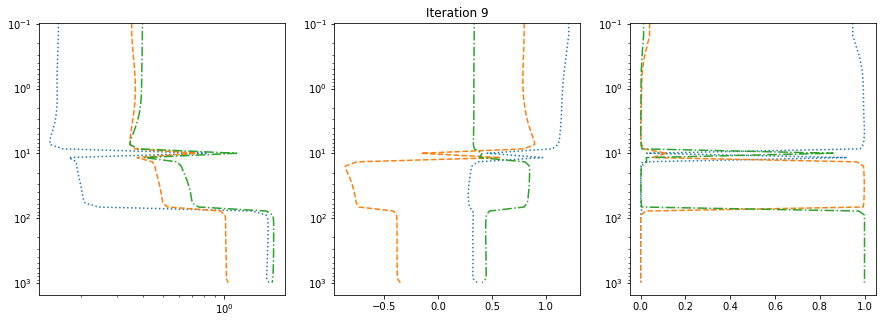

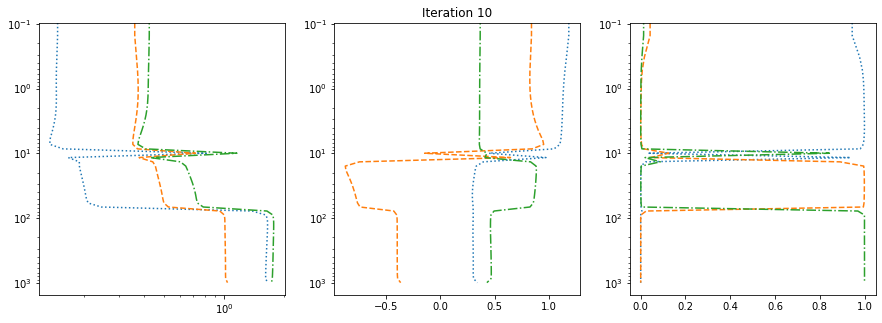

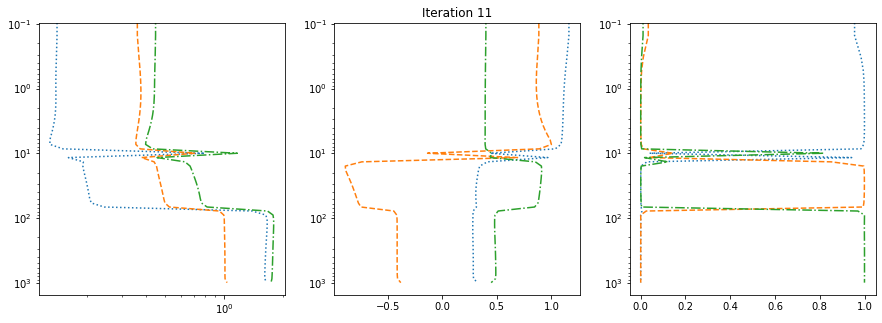

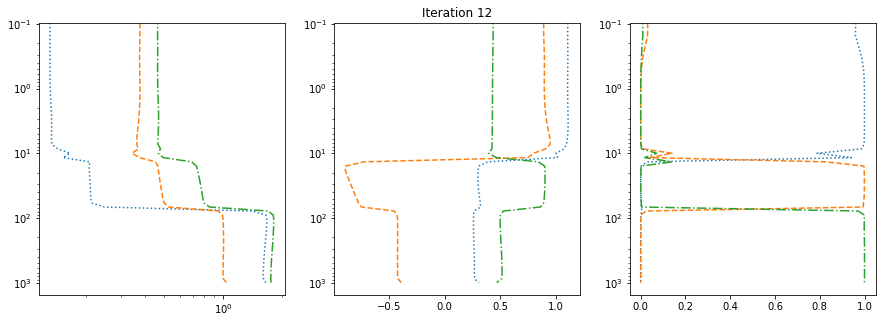

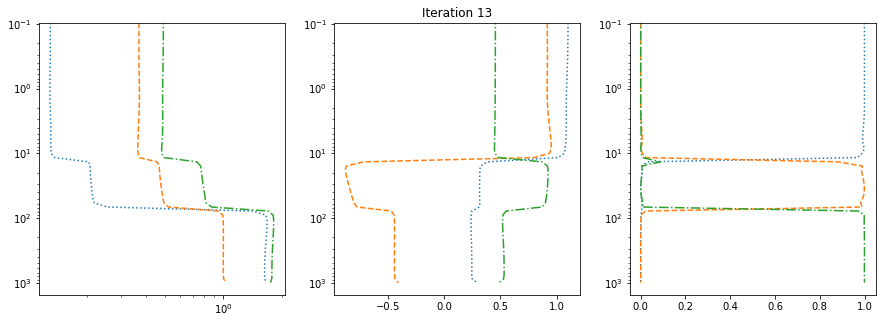

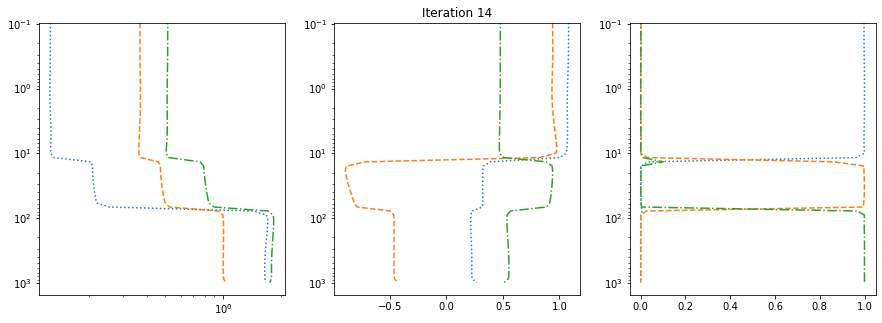

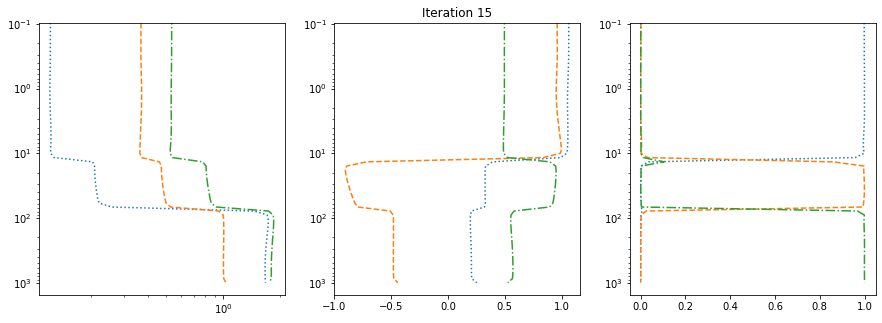

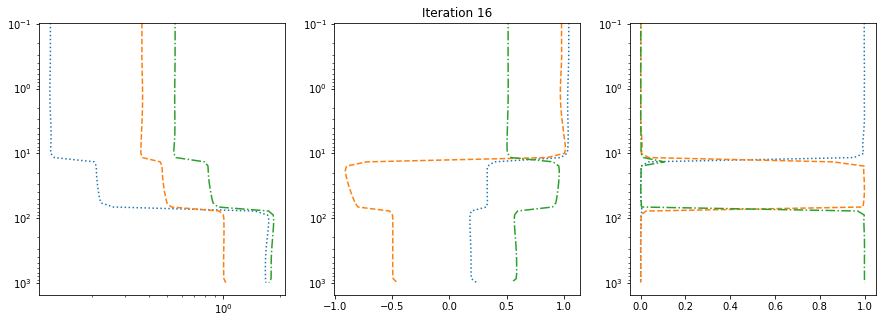

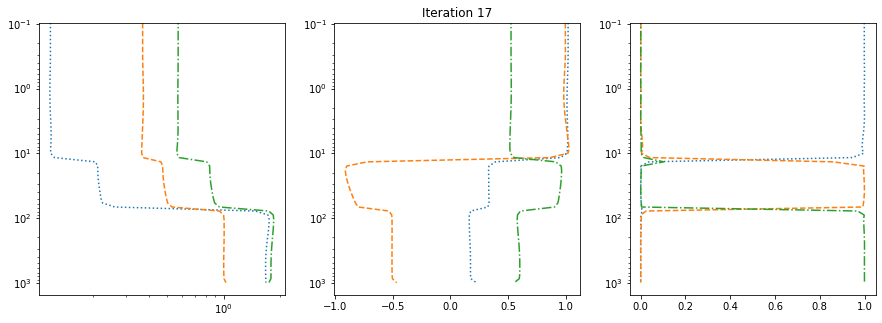

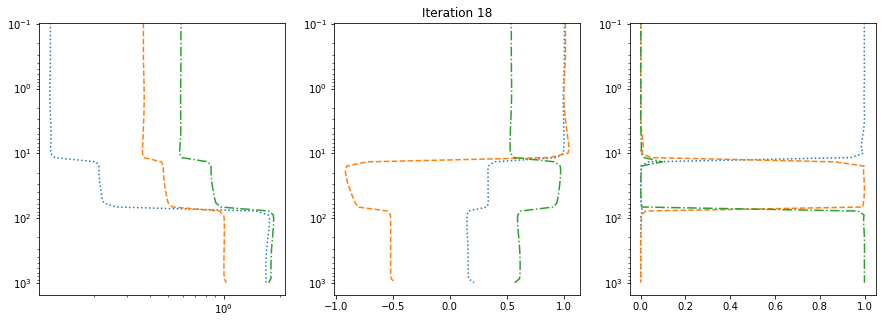

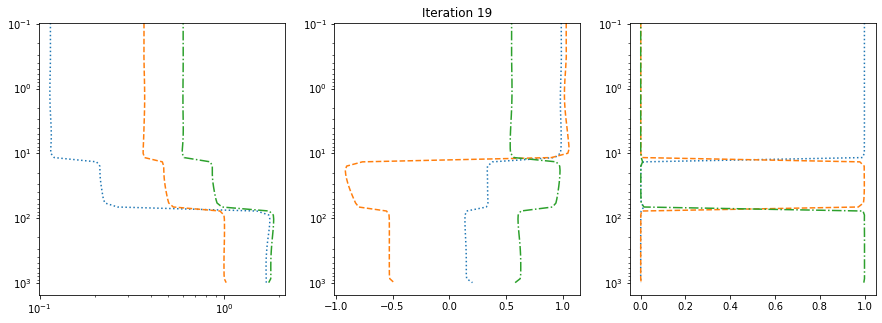

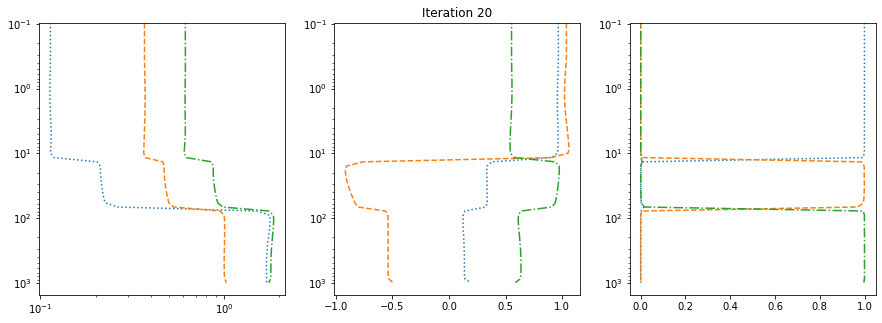

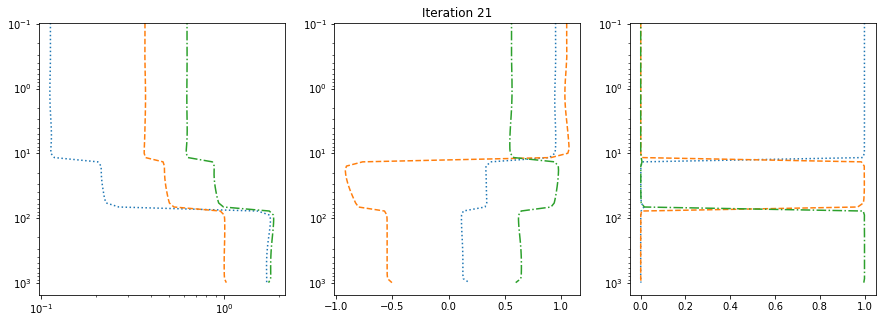

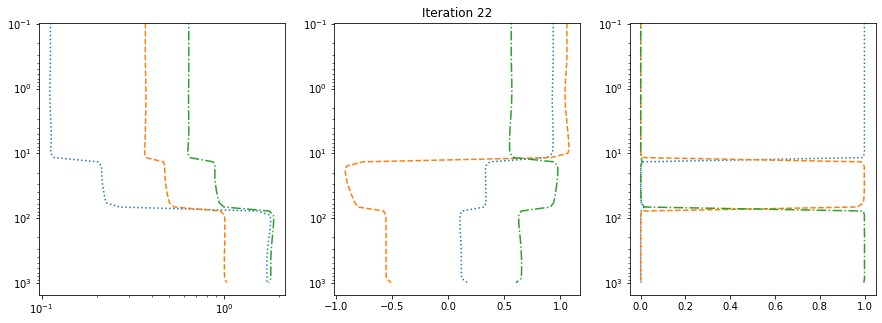

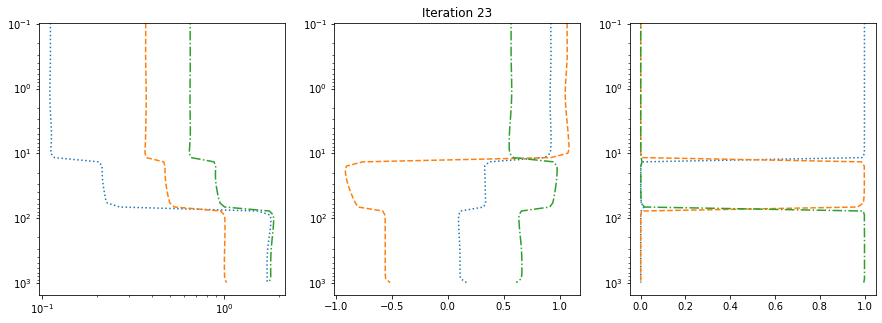

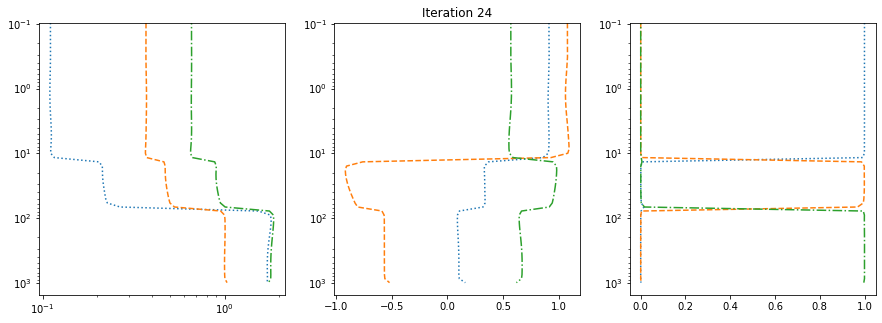

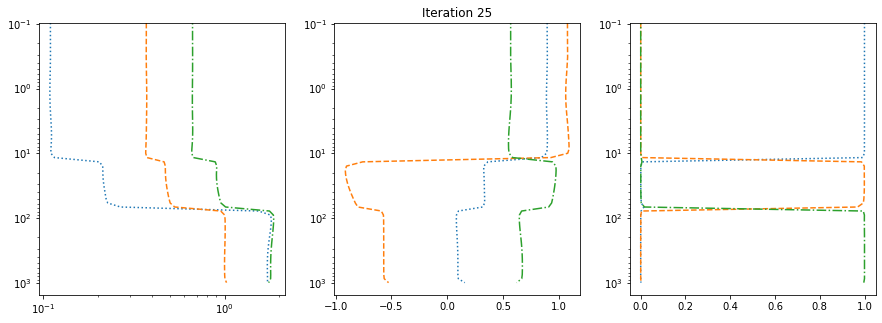

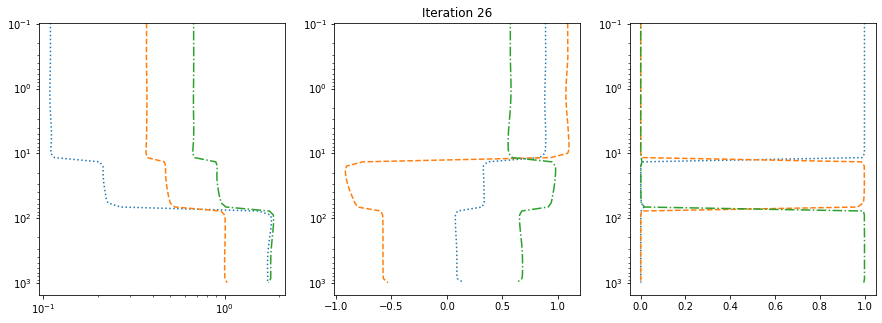

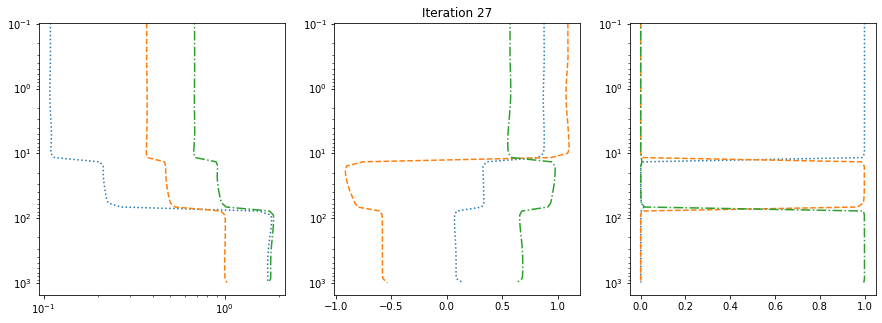

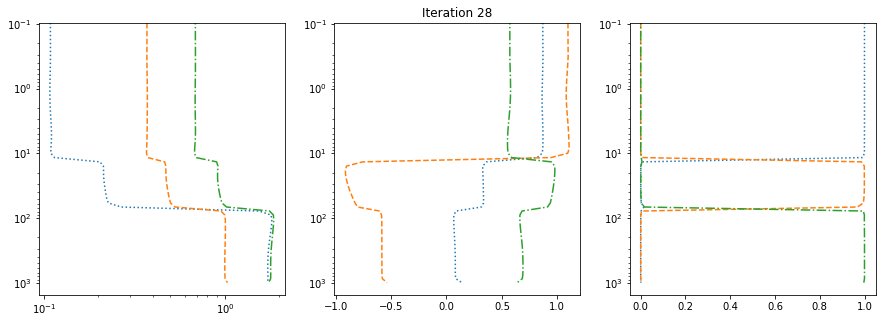

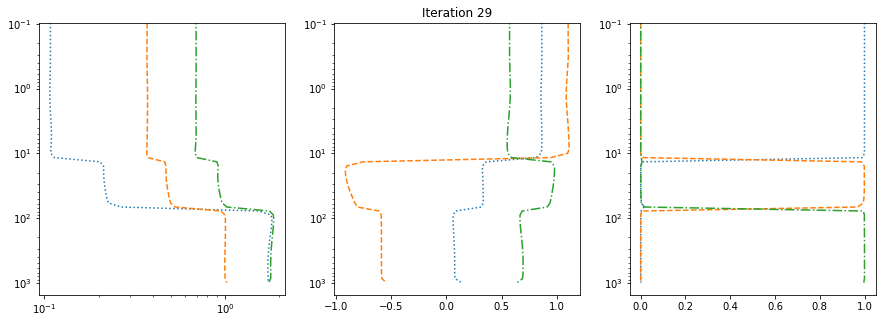

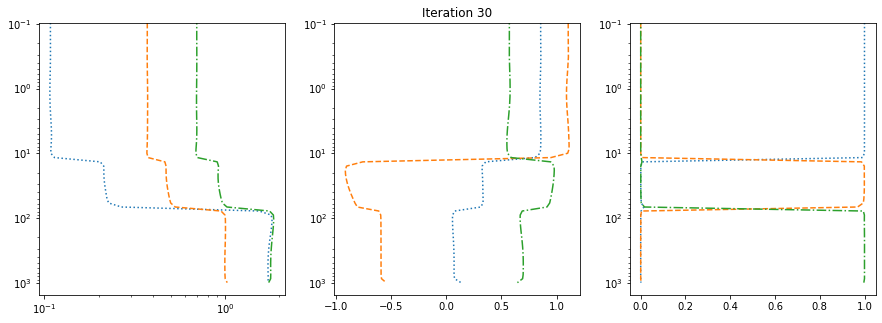

In [26]:
beta = 1.0
lamb = 1000
eta = 2

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v, w=[1,1,1,1,1,1])
PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta,  w=np.array([0.01,0.01,0.01,1]))

u=PhiFCM_eff.updateU(m_eff, tk_eff)
PhiFCM.u = PhiFCM_eff.u

Phi = PhiD+beta*PhiM2+lamb*PhiFCM

vi = tk.copy()
PhiFCM.update_internals()
print(xi.shape)

callback(xi)
phimkm1 = PhiM(xi)
xis = []
for i in range(30):
    #print('Iteration', i+1)
    #if i>6:
    #    eta *= 1.1
        
    ###
    # Update v based on xi and effective and u
    v = PhiFCM.updateV(xi, u, eta)
    v_eff = v.copy()
    v_eff[:,:3] = np.exp(v_eff[:,:3])
    v_eff = np.c_[eff_anis_trans(*v_eff.T)]
    v_eff[:, :3] = np.log(v_eff[:,:3])
    
    m_eff = xi.reshape(6, n_inv_layers).copy()
    m_eff[:3] = np.exp(m_eff[:3])
    m_eff = np.r_[eff_anis_trans(*m_eff)].reshape(4, n_inv_layers)
    m_eff[:3] = np.log(m_eff[:3])
    m_eff = m_eff.reshape(-1)
    
    norm1 = np.linalg.norm(v-tk)
    norm2 = np.linalg.norm(v_eff-tk_eff)
    print(norm1, norm2)
    if norm2<norm1:
        # Update membership using v_eff
        u = PhiFCM_eff.updateU(m_eff, v_eff)
    else:
        u = PhiFCM.updateU(xi.reshape(6, -1), v)
    PhiFCM.u = u
    
    PhiFCM.update_internals()
    ###
    print(v, PhiFCM(xi.reshape(-1)))
    
    Phi = PhiD+beta*PhiM2+lamb*PhiFCM
    
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p), tol=1E-2,
                  callback=callback)
    xi = out['x']
    xis.append(xi)
    plot_model(xi, PhiFCM.u, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    phimk = PhiM(xi)
    rel_phim = np.abs(phimk-phimkm1)/phimkm1
    #print(rel_phim)
    if(rel_phim<1E-4):
        break
    phimkm1 = phimk
    

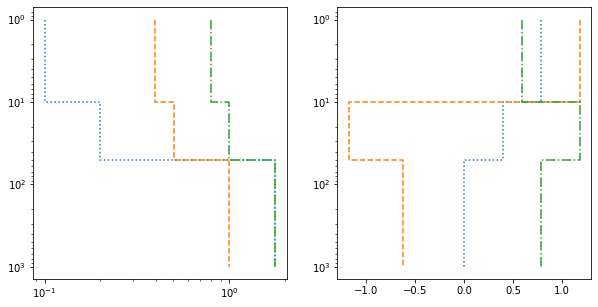

In [27]:
z = forward_space._z
zplot = np.array([1,z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(s1plot, zplot, ':')
plt.loglog(s2plot, zplot, "--")
plt.loglog(s3plot, zplot, "-.")
plt.gca().invert_yaxis()

aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])
plt.subplot(1,2,2)
plt.semilogy(aplot,zplot,':')
plt.semilogy(bplot,zplot,"--")
plt.semilogy(gplot,zplot,"-.")
plt.gca().invert_yaxis()

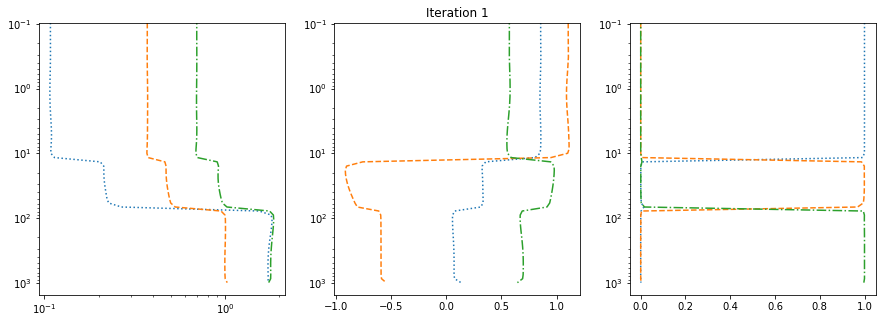

In [28]:
plot_model(xi, PhiFCM.u, 0)

In [29]:
np.linalg.norm(v-tk), np.linalg.norm(v_eff-tk_eff)

(0.4179099391688271, 0.5188624254872909)

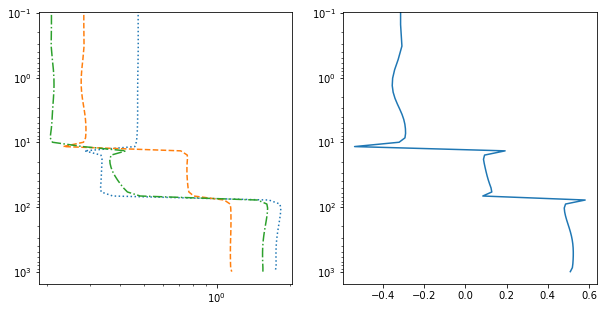

In [30]:
# Plot Effective Anisotropy:
mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

In [31]:
np.save(mod_folder + 'm_fcm_eff',xi)
PhiD(xi)

129.53010108897982

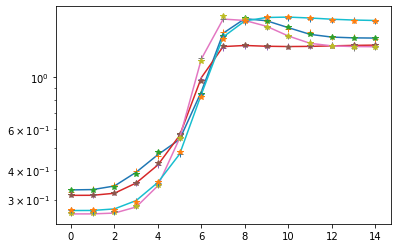

In [32]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.semilogy(rhoa_true[15*i:(i+1)*15], label=i)
    plt.semilogy(rhoa_obs[15*i:(i+1)*15],'+')
    plt.semilogy(rhoa_pre[15*i:(i+1)*15],'*')

In [33]:
x = np.load(mod_folder + 'beta1.npy'); PhiD(xi);
rhoa_pre1 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

x = np.load(mod_folder + 'm_fcm_eff.npy'); PhiD(xi);
rhoa_pre2 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

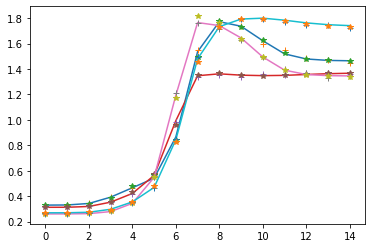

In [34]:
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre2[15*i:(i+1)*15],'*')

In [35]:
np.savez(mod_folder + 'data',
         rhoa_true=rhoa_true,
         rhoa_obs=rhoa_obs,
         rhoa_smooth=rhoa_pre1,
         rhoa_fcm=rhoa_pre2)